<a href="https://colab.research.google.com/github/Glitch0000/Graph_Mode_in_TensorFlow/blob/main/Graph_Mode_in_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Horse vs Human using graph mode

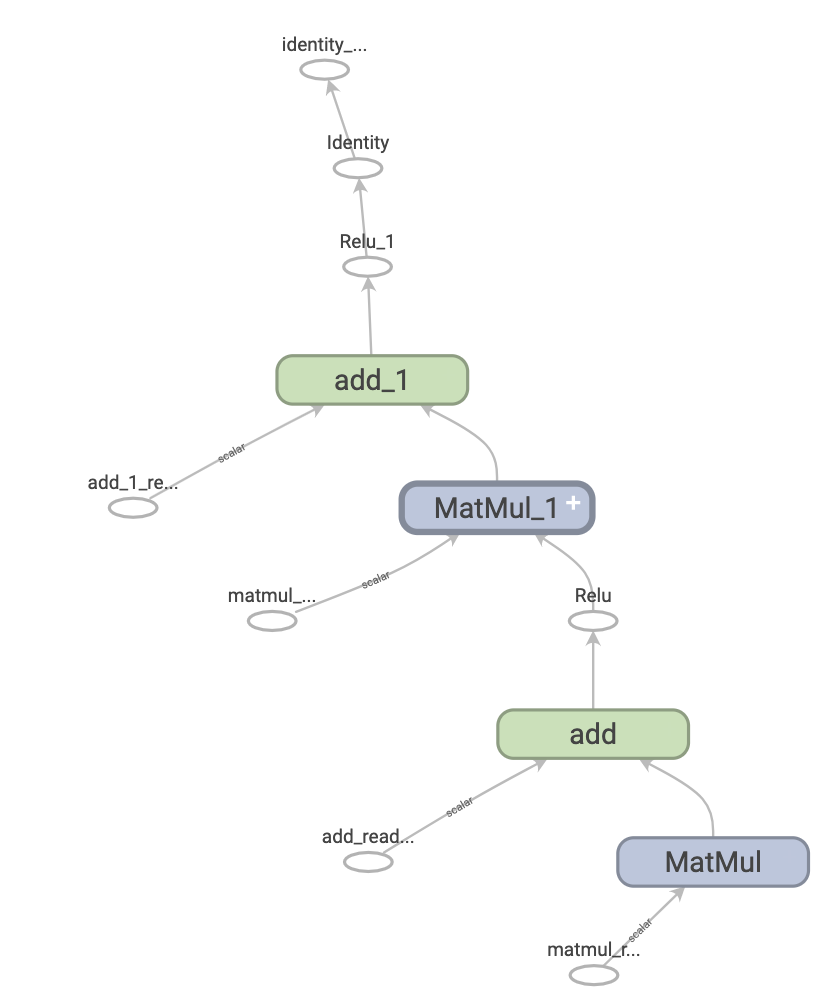


Graphs are data structures that contain a set of tf.Operation objects, which represent units of computation; and tf.Tensor objects, which represent the units of data that flow between operations. They are defined in a tf.Graph context. Since these graphs are data structures, they can be saved, run, and restored all without the original Python code.


The steps are:
- loading batches
- calculating gradients
- updating parameters
- calculating validation accuracy
- repeating the loop until convergence

## Setup

Import TensorFlow 2.0:

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import matplotlib.pyplot as plt

### Prepare the dataset

Load the horses to human dataset, splitting 80% for the training set and 20% for the test set.

In [5]:
splits, info = tfds.load('horses_or_humans', as_supervised=True, with_info=True, split=['train[:80%]', 'train[80%:]', 'test'], data_dir='./data')

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

## Pre-process an image 

We'll define a mapping function that resizes the image to a height of 224 by 224, and normalizes the pixels to the range of 0 to 1.  Note that pixels range from 0 to 255.

- We'll use the following function: [tf.image.resize](https://www.tensorflow.org/api_docs/python/tf/image/resize) and pass in the (height,width) as a tuple (or list).
- To normalize, divide by a floating value so that the pixel range changes from [0,255] to [0,1].

In [7]:
# Create a autograph pre-processing function to resize and normalize an image
### START CODE HERE ###
@tf.function
def map_fn(img, label):
    image_height = 224
    image_width = 224
    # resize the image
    img = tf.image.resize(img, [image_height, image_width])
    # normalize the image
    img /= 255.0
    return img, label

## Apply pre-processing to the datasets

Apply the following steps to the training_examples:
- Apply the `map_fn` to the training_examples
- Shuffle the training data using `.shuffle(buffer_size=)` and set the buffer size to the number of examples.
- Group these into batches using `.batch()` and set the batch size given by the parameter.
.

In [9]:
# Prepare train dataset by using preprocessing with map_fn, shuffling and batching
def prepare_dataset(train_examples, validation_examples, test_examples, num_examples, map_fn, batch_size):
    train_ds = train_examples.map(map_fn).batch(batch_size)
    train_ds = train_ds.shuffle(num_examples)
    valid_ds = validation_examples.map(map_fn).batch(batch_size)
    test_ds = test_examples.map(map_fn).batch(batch_size)
    
    return train_ds, valid_ds, test_ds

In [10]:
train_ds, valid_ds, test_ds = prepare_dataset(train_examples, validation_examples, test_examples, num_examples, map_fn, BATCH_SIZE)

### Define the model

In [12]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image img_size x img_size with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # # The fifth convolution
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(2, activation='softmax')# number of classes, in case we have binary classification:(1, activation='sigmid')
])

## Define optimizer:
Define the [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) that is in the tf.keras.optimizers module.

In [13]:
def set_adam_optimizer():
    # Define the adam optimizer
    optimizer = tf.keras.optimizers.Adam()
    return optimizer

## Define the loss function

Define the loss function as the [sparse categorical cross entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) that's in the tf.keras.losses module.  Use the same function for both training and validation.

In [15]:
def set_sparse_cat_crossentropy_loss():
    # Define object oriented metric of Sparse categorical crossentropy for train and val loss
    train_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    val_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    return train_loss, val_loss

## Define the acccuracy function
Define the accuracy function as the [spare categorical accuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalAccuracy) that's contained in the tf.keras.metrics module.   Use the same function for both training and validation.

In [17]:
def set_sparse_cat_crossentropy_accuracy():
    # Define object oriented metric of Sparse categorical accuracy for train and val accuracy
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    return train_accuracy, val_accuracy

Now we call the three functions that we defined to set the optimizer, loss and accuracy

In [18]:
optimizer = set_adam_optimizer()
train_loss, val_loss = set_sparse_cat_crossentropy_loss()
train_accuracy, val_accuracy = set_sparse_cat_crossentropy_accuracy()

### Define the training loop

In the training loop:
- Get the model predictions: use the model, passing in the input `x`
- Get the training loss: Call `train_loss`, passing in the true `y` and the predicted `y`.
- Calculate the gradient of the loss with respect to the model's variables: use `tape.gradient` and pass in the loss and the model's `trainable_variables`.
- Optimize the model variables using the gradients: call `optimizer.apply_gradients` and pass in a `zip()` of the two lists: the gradients and the model's `trainable_variables`.
- Calculate accuracy: Call `train_accuracy`, passing in the true `y` and the predicted `y`.

In [19]:
# this code uses the GPU if available, otherwise uses a CPU
device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'
EPOCHS = 2

# Custom training step
def train_one_step(model, optimizer, x, y, train_loss, train_accuracy):
    '''
    Trains on a batch of images for one step.
    
    Args:
        model (keras Model) -- image classifier
        optimizer (keras Optimizer) -- optimizer to use during training
        x (Tensor) -- training images
        y (Tensor) -- training labels
        train_loss (keras Loss) -- loss object for training
        train_accuracy (keras Metric) -- accuracy metric for training
    '''
    with tf.GradientTape() as tape:
        # Run the model on input x to get predictions
        predictions = model(x)
        # Compute the training loss using `train_loss`, passing in the true y and the predicted y loss = train_loss(y_true=y, y_pred=predictions)
        loss = train_loss(y, predictions)

    # Using the tape and loss, compute the gradients on model variables using tape.gradient GL trainable_weights
    grads = tape.gradient (loss, model.trainable_variables)
    
    # Zip the gradients and model variables, and then apply the result on the optimizer
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Call the train accuracy object on ground truth and predictions  train_accuracy(y_true=y, y_pred=predictions
    train_accuracy(y, predictions)
    return loss

## Define the 'train' function

We'll first loop through the training batches to train the model. (Please complete these sections)
- The `train` function will use a for loop to iteratively call the `train_one_step` function that we just defined.
- We'll use `tf.print` to print the step number, loss, and train_accuracy.result() at each step.  Remember to use tf.print when we plan to generate autograph code.

Next, we'll loop through the batches of the validation set to calculation the validation loss and validation accuracy. (This code is provided for we).  At each iteration of the loop:
- Use the model to predict on x, where x is the input from the validation set.
- Use val_loss to calculate the validation loss between the true validation 'y' and predicted y.
- Use val_accuracy to calculate the accuracy of the predicted y compared to the true y.

Finally, we'll print the validation loss and accuracy using tf.print. (Please complete this section)
- print the final `loss`, which is the validation loss calculated by the last loop through the validation dataset.
- Also print the val_accuracy.result().


In [21]:
# Decorate this function with tf.function to enable autograph on the training loop
@tf.function
def train(model, optimizer, epochs, device, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy):
    '''
    Performs the entire training loop. Prints the loss and accuracy per step and epoch.
    
    Args:
        model (keras Model) -- image classifier
        optimizer (keras Optimizer) -- optimizer to use during training
        epochs (int) -- number of epochs
        train_ds (tf Dataset) -- the train set containing image-label pairs
        train_loss (keras Loss) -- loss function for training
        train_accuracy (keras Metric) -- accuracy metric for training
        valid_ds (Tensor) -- the val set containing image-label pairs
        val_loss (keras Loss) -- loss object for validation
        val_accuracy (keras Metric) -- accuracy metric for validation
    '''
    step = 0
    loss = 0.0
    for epoch in range(epochs):
        for x, y in train_ds:
            # training step number increments at each iteration
            step += 1
            with tf.device(device_name=device):
                #train_one_step(model, optimizer, x, y, train_loss, train_accuracy)
                # Run one training step by passing appropriate model parameters
                # required by the function and finally get the loss to report the results
                loss = train_one_step(model, optimizer, x, y, train_loss, train_accuracy)
            # Use tf.print to report our results.
            # Print the training step number, loss and accuracy
            tf.print('Step', step, 
                   ': train loss', loss, 
                   '; train accuracy', train_accuracy.result())

        with tf.device(device_name=device):
            for x, y in valid_ds:
                # Call the model on the batches of inputs x and get the predictions
                y_pred = model(x)
                loss = val_loss(y, y_pred)
                val_accuracy(y, y_pred)
        
        # Print the validation loss and accuracy
        tf.print('val loss', loss, '; val accuracy', val_accuracy.result())

The loss generally decreasing and the accuracy increasing.
 

In [22]:
train(model, optimizer, EPOCHS, device, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy)

Step 1 : train loss 0.690340042 ; train accuracy 0.53125
Step 2 : train loss 3.92009306 ; train accuracy 0.546875
Step 3 : train loss 1.24777746 ; train accuracy 0.489583343
Step 4 : train loss 0.60082 ; train accuracy 0.5546875
Step 5 : train loss 0.607720733 ; train accuracy 0.5625
Step 6 : train loss 0.547533333 ; train accuracy 0.583333313
Step 7 : train loss 0.527538955 ; train accuracy 0.633928597
Step 8 : train loss 0.500047505 ; train accuracy 0.66796875
Step 9 : train loss 0.438785613 ; train accuracy 0.690972209
Step 10 : train loss 0.408768117 ; train accuracy 0.709375
Step 11 : train loss 0.321790367 ; train accuracy 0.725146174
Step 12 : train loss 0.288209349 ; train accuracy 0.745989323
Step 13 : train loss 0.365639627 ; train accuracy 0.756157637
Step 14 : train loss 0.194397107 ; train accuracy 0.771689475
Step 15 : train loss 0.1277643 ; train accuracy 0.787234068
Step 16 : train loss 0.14798364 ; train accuracy 0.796812773
Step 17 : train loss 0.21123004 ; train accu

# Evaluation

We can now see how our model performs on test images. First, let's load the test dataset and generate predictions:

In [23]:
test_imgs = []
test_labels = []

predictions = []
with tf.device(device_name=device):
    for images, labels in test_ds:
        preds = model(images)
        preds = preds.numpy()
        predictions.extend(preds)

        test_imgs.extend(images.numpy())
        test_labels.extend(labels.numpy())

Let's define a utility function for plotting an image and its prediction.

In [24]:
# Utilities for plotting

class_names = ['horse', 'human']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    
    # green-colored annotations will mark correct predictions. red otherwise.
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    # print the true label first
    print(true_label)
  
    # show the image and overlay the prediction
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)



### Plot the result of a single image

Choose an index and display the model's prediction for that image.

0


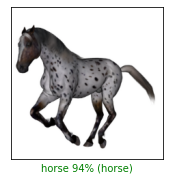

In [25]:
# Visualize the outputs 

# we can modify the index value here from 0 to 255 to test different images
index = 8 
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()